# Sentences (1).json exploration

This notebook is an exploration of the data in the 'Sentences (1).json' file. The file contains a list of 100 sentences. As the sentences are simple and short they are ideal for applicate NLP tasks such as topic modeling, data augmentation,
fine-tuning LLM and classification tasks.

In [1]:
import json
with open('sentences (1).json','r') as file:
    sentences = json.load(file)
print(sentences[0:3])

["The dragonfly's wings sparkled like gemstones in the sunlight.", 'The bagpipes were adorned with a tartan pattern, honoring Scottish tradition.', 'The fur pattern on the tiger was striking and intimidating.']


## 1. Topic Modeling

The first task is to perform topic modeling on the sentences. The goal is to identify the main topics in the sentences. For this purpose, we follow the following steps:

1. Topic Extraction: Extract the main topic from each sentence.
2. Clustering: Cluster the sentences based on the topics extracted.
3. Labeling: Label the clusters based on the topics extracted.


### 1.1 Topic Extraction

To extract the main topic from each sentence, we use the Spacy library. https://spacy.io/usage/spacy-101. Spacy is a powerful NLP library that provides a wide range of functionalities for NLP tasks. 

Spacy provides prertrained pipelines with the following components:

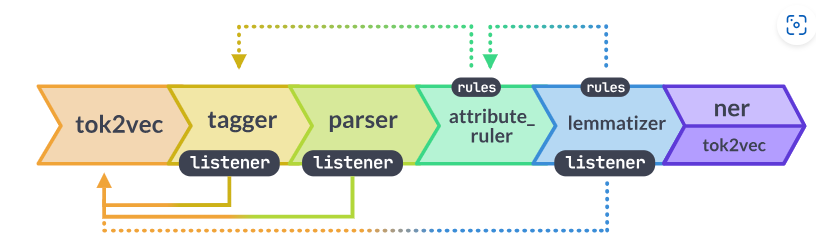

In particular, dependency parsing and part-of-speech (POS) tagging can be used to extract the subject of a sentence. As the sentences are simple and short, we can assume that the subject of the sentence is the main topic.

In [2]:
# Function to extract the subject.
import spacy
nlp = spacy.load('en_core_web_md')

def get_subject_phrase(doc):
    for token in doc:
        if ("subj" in token.dep_):
            subtree = list(token.subtree)
            start = subtree[0].i
            end = subtree[-1].i + 1
            return doc[start:end]

sentences_topics = [get_subject_phrase(nlp(sentence)) for sentence in sentences]
print(sentences_topics[0:3])

[The dragonfly's wings, The bagpipes, The fur pattern on the tiger]


In [3]:
# Function to delete non informative words of the topics.
def delete_non_informative_words(text):
    doc = nlp(text)
    informative_words = [token.text for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(informative_words)

sentences_topics_cleaned = [delete_non_informative_words(str(topic)) for topic in sentences_topics]

### 1.2 Clustering

To cluster the sentences, firstly we need to create vectors from the sentences. For that purpose, we can use sentence_transformers library. Other libraries such as BERT, GloVe were be discussed, however, sentence_transformers is chosen as reduce a lot the computational cost for tasks as semantic similarity, clustering, etc. Also, it outperforms methods like InferSent and Universal Sentence Encoder across various tasks, including semantic textual similarity (STS) and argument facet similarity. (*Reimers & Gurevych, 2019*)

For this reason, as our clustering task is based on semantic similarity, as we are looking to group sentences with similar topics, i.e. topics that are semantically similar. Then, a pre-trained LLM for semantic textual similarity is chosen: 'all-mpnet-base-v2'.

As this model is pre-trained in a very large corpus (used the pretrained microsoft/mpnet-base model and fine-tuned in on a 1B sentence pairs dataset), it is expected to perform well in the task of create accurate sentence embeddings for clustering.







In [4]:
# Embeddings of cleaned topics
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')

topic_embeddings_cleaned = model.encode(sentences_topics_cleaned)

C:\Users\pablo\AppData\Roaming\Python\Python311\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### Clustering Algorithm

Once the embeddings are created, we can use different clustering techniques: Hard Clustering (KMeans, DBSCAN, etc) or Soft Clustering (Gaussian Mixture Models, etc). in this case, soft clustering is chosen, in particular, **Gaussian Mixture Models (GMM)** because GMM provides the flexibility to model the uderlying data distributuion as a mixture of several Gaussian components.  Unlike hard clustering methods like KMeans, which assign each data point to a single cluster, GMM allows for probabilistic assignments. This means that each sentence embedding can belong to multiple clusters with different degrees of membership, which is particularly useful in scenarios where the data may have overlapping clusters or ambiguous boundaries.

The soft clustering capability of GMM aligns well with the nature of sentence embeddings, which often capture semantic nuances and may not form distinct clusters in the embedding space. Additionally, GMM accommodates different cluster shapes and sizes by modeling the covariance of the data, making it more robust to variations in the geometry of the embedding space compared to methods like KMeans.

Furthermore, GMM leverages Expectation-Maximization (EM) to iteratively optimize the likelihood of the data given the model, enabling it to better fit complex distributions. This adaptability makes GMM a suitable choice for tasks involving natural language embeddings, where the data is high-dimensional and potentially exhibits non-linear relationships.

*https://builtin.com/articles/gaussian-mixture-model*

### Number of Clusters

The number of clusters is chosen based on the silhouette score. The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). In this case, we use the silhouette coefficient, which is the mean silhouette score of all samples, to evaluate the clustering performance. *(Kaufman & Rousseeuw, 1990)*


As the GMM algorithm starts with a random initialization of the cluster centers, the number of clusters is chosen based on the highest silhouette score for different random initializations.


In [5]:
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

best_score = -1
score = 0

for random_state in range(0,100):
    for num_clusters in range(2,15):
        score = silhouette_score(topic_embeddings_cleaned, GaussianMixture(n_components=num_clusters, covariance_type='spherical', random_state= random_state).fit_predict(topic_embeddings_cleaned),
                                 metric = 'cosine')
        if score > best_score:
            best_score = score
            best_num_clusters = num_clusters
            best_random_state = random_state

print(best_score, best_num_clusters, best_random_state)

C:\Users\pablo\AppData\Roaming\Python\Python311\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


0.14142804 6 33


In [6]:
gmm_model = GaussianMixture(n_components=best_num_clusters, covariance_type='spherical', random_state= best_random_state)
gmm_labels = gmm_model.fit_predict(topic_embeddings_cleaned)

clusters = {}
for i, label in enumerate(gmm_labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(sentences_topics_cleaned[i])
    
for label, items in clusters.items():
    print(f"Cluster {label}: {items}")

Cluster 2: ['dragonfly wings', 'fur pattern tiger', 'triangle', 'porcupine', 'dolphin streamlined shape', 'octopus', 'carnivorous pitcher plant', 'kangaroo', 'anteater', 'condor wingspan', 'size blue whale', 'Venus flytrap', 'peacock', 'elephant', 'feathers bald eagle', 'chameleon', 'kitten', 'platypus', 'zebra black white stripes', 'hamster', 'ladybug red black contrast', 'flamingo pink hue', 'hedgehog spines']
Cluster 0: ['bagpipes', 'didgeridoo', 'tuba', 'violin', 'synthesizer', 'saxophone', 'harp', 'drum set', 'harmonica', 'kazoo', 'accordion', 'banjo', 'flute', 'maracas', 'fireworks', 'piccolo', 'grand piano', 'electric guitar']
Cluster 1: ['sequoia tree', 'mimosa plant', 'dandelion seed head', 'petals rose', 'aloe vera plant', 'cherry blossoms', 'lavender', 'lotus flower', 'pumpkin vine', 'red maple leaves autumn', 'blue orchids', 'sunflower', 'coffee plant', 'ivy', 'bonsai', 'fountain', 'bamboo stalks', 'cactus', 'intricate veins fern leaf']
Cluster 4: ['microchip', 'origami cra

In [7]:
#Dictionary of list of each clusters and their sentences
sentences_grouped = {}
for i, label in enumerate(gmm_labels):
    if label not in sentences_grouped:
        sentences_grouped[label] = []
    sentences_grouped[label].append(sentences[i])

### 1.3 Labeling

Observing the clusters, it can be seen that the sentences are accurately grouped based on the topics extracted. However, we would like to create a representative label for each cluster, that encompasses the broad topic of the cluster. 

To achieve this, we are going to use text generation with a LLM and the Hugging Face API,  to generate a label for each cluster. The LLM chosen is **"Mixtral-8x7B-Instruct-v0.1"**, which is a pretrained Sparse Mixture of Experts for text generation. This model, outperforms Llama 2 and GPT3.5 in a wide range of tasks (*https://mistral.ai/news/mixtral-of-experts/*), and can be used directly from the Hugging Face API.

In [8]:
from huggingface_hub import notebook_login
notebook_login()

import requests
import os
from dotenv import load_dotenv
load_dotenv()
headers = {"Authorization": f"Bearer {os.getenv('HF_TOKEN')}"}

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [9]:
from huggingface_hub import InferenceClient
cluster_labels = {}
client = InferenceClient("mistralai/Mixtral-8x7B-Instruct-v0.1")
prompt = [
    {"role": "system", "content": "You will be provided with a list of keywords of common theme, and your task is based on these keywords, suggest a very short, descriptive label that best represents the theme of the list."},
    {"role": "user", "content": "Keywords: [KEYWORDS]"}
]

# response format for the API to return the topic labels
response_format = {
    "type": "json",
    "value": {
        "properties": {
            "topic_label": {"type": "string"}            
        },
        "required": ["topic_label"]
        }
    }


for cluster, keywords in clusters.items():
    keywords_string = ', '.join(keywords)
    custom_prompt = [
        {"role": "system", "content": prompt[0]["content"]},
        {"role": "user", "content": prompt[1]["content"].replace("[KEYWORDS]", keywords_string)}
    ]
    response = client.chat.completions.create(
        messages=custom_prompt,
        response_format=response_format,
        max_tokens = 64,
    )
    
    print(response.choices[0].message.content)
    
    cluster_labels[cluster] = json.loads(response.choices[0].message.content)["topic_label"]
    

{"topic_label": "Animal Features and Adaptations"}
{"topic_label": "Musical Instruments and Sound Effects"}
{"topic_label": "Diverse Plant Life and Natural Formations"}
{"topic_label": "Technology and Design"}
{"topic_label":"Various Vehicles and Transportation"

}
{"topic_label": "Art and Architectural Designs"}


The labels extracted are also highly accurate and representative of the topics in the clusters. Therefore, we store the data in a pandas dataframe.

In [10]:
# Dataframe with the sentences and their corresponding cluster labels
import pandas as pd 
rows = []
for label, sentences in sentences_grouped.items():
    for sentence in sentences:
        rows.append({"Sentence": sentence, "Topic": cluster_labels[label]})

df = pd.DataFrame(rows, columns = rows[0].keys())

df = df.sample(frac=1).reset_index(drop=True)

df.head()


,Sentence,Topic
0,The hedgehog's spines were surprisingly beauti...,Animal Features and Adaptations
1,"The pumpkin vine spread out over a vast area, ...",Diverse Plant Life and Natural Formations
2,The RV had a retractable awning that provided ...,Various Vehicles and Transportation
3,"The octopus had remarkable intelligence, solvi...",Animal Features and Adaptations
4,The virtual reality headset offered an immersi...,Technology and Design


## 2. Data Augmentation

Data augmentation is a technique used to increase the size of the training data by creating new samples from the existing data. We create synthetic data by using the previous LLM model, **"Mixtral-8x7B-Instruct-v0.1"** to generate new sentences based on the existing sentences. The generated sentences are then added to the original dataset.

In [11]:
# Data Augmentation
from huggingface_hub import InferenceClient

# Initialize the inference client
client = InferenceClient("mistralai/Mixtral-8x7B-Instruct-v0.1")

df_augmented = df.copy()

for topic in df['Topic'].unique():
    
    custom_prompt = [
        {
            "role": "system",
            "content": (
                "You will be provided with a topic. Your task is to create exactly 50 diverse short sentences "
                "that are conceptually related to the topic. The sentences should not necessarily mention the topic "
                "but should reflect ideas, attributes, or elements connected to it. For example, if the topic is 'plants,' "
                "a valid sentence could be, 'Rosemary smells nice.'"
            )
        },
        {"role": "user", "content": f"Topic: {topic}"}
    ]
    
    # Call the model
    response = client.chat.completions.create(
        messages=custom_prompt,
        max_tokens = 2000
    )
    
    # Process the output to extract sentences
    sentences = response.choices[0].message.content
    print(f"Topic: {topic}")
    print(sentences)
    # Extract the sentences from the response and add to the dataframe
    sentences = sentences.strip().split("\n")
    sentences = [line.split('. ', 1)[1] for line in sentences]
    rows =[]
    for sentence in sentences:
        rows.append({"Sentence": sentence, "Topic": topic})
    
    df_augmented = pd.concat([df_augmented, pd.DataFrame(rows, columns = rows[0].keys())], ignore_index=True)

Topic: Animal Features and Adaptations
 1. The chameleon's color-changing skin helps it regulate body temperature and communicate with others.
2. A dog's strong sense of smell is crucial for hunting, tracking, and social bonding.
3. The sharp claws of a snow leopard provide excellent traction on icy mountain terrain.
4. Seagulls have adapted to eat a wide variety of foods, from fish to french fries.
5. A giraffe's long neck enables it to reach leaves that other herbivores can't.
6. The ability of a kangaroo to jump long distances at high speeds helps it evade predators.
7. A polar bear's white fur provides camouflage in the snowy Arctic landscape.
8. The camouflage of a leaf-tailed gecko allows it to blend in with its environment.
9. The aerodynamic shape of a humpback whale's tail aids in maneuverability and communication.
10. The venomous spines of a lionfish deter predators and aid in hunting.
11. The trunk of an elephant is a versatile tool for foraging, communication, and social i

In [12]:
df_augmented.info()
# Save the dataframe to a json file in the current directory
df_augmented.to_json("augmented_data.json", orient="records", lines=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  401 non-null    object
 1   Topic     401 non-null    object
dtypes: object(2)
memory usage: 6.4+ KB


In [13]:
# Create a dictionary to map topics to numbers
topic_to_number = {topic: i for i, topic in enumerate(df['Topic'].unique())}

# Map the topics to numbers
df_augmented['Topic'] = df_augmented['Topic'].map(topic_to_number)

## 3. Fine-Tune LLM and Classification

The selected method for fine-tune and classification is a [SetFit](https://github.com/huggingface/setfit) Model together with [BAAI/bge-small-en-v1.5](https://huggingface.co/BAAI/bge-small-en-v1.5). This SetFit model uses *BAAI/bge-small-en-v1.5* as the Sentence Transformer embedding model and a simple feed forward neural network as the classifier. 

Our custom dataset is used to train the model, using the efficient few-shot learning technique of SetFit (*Tunstall et al., 2022*), which involves:

* Fine-Tuning a Sentence Transformer with contrastive learning. 
* Training a classification head with features from the fine-tuned Sentence transformer.

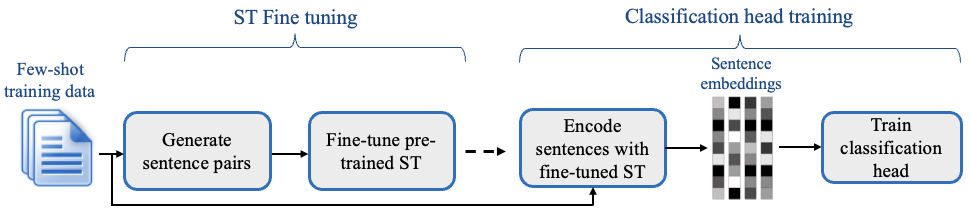 

By default, the SetFit model uses a LogisticRegression model as the classifier. However, we use the feed forward neural network classifier for apply different features of the model. The default model is faster but this PyTorch implementation is more flexible and can be used for more complex tasks. 

In this case, we use only 8 labeled example per class to fine-tune the model, which is 48 sentences. We also, consider 60 samples with 10 samples per class to validation dataset for hyperparameter tuning. And Finally, we use 292 test samples to evaluate the model. 



In [14]:
from setfit import sample_dataset
import datasets
from sklearn.model_selection import train_test_split

# Convert to dataset
dataset = datasets.Dataset.from_pandas(df_augmented)

# Split the dataset
train_dataset = sample_dataset(dataset, label_column = 'Topic', num_samples = 8)
rest_dataset = dataset.filter(lambda x: x not in train_dataset)

val_dataset = sample_dataset(rest_dataset, label_column='Topic', num_samples = 10)

test_dataset = rest_dataset.filter(lambda x: x not in val_dataset)

# Shapes of the datasets
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(val_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")


Filter:   0%|          | 0/401 [00:00<?, ? examples/s]

Filter:   0%|          | 0/353 [00:00<?, ? examples/s]

Train dataset: 48 samples
Validation dataset: 60 samples
Test dataset: 293 samples


In [17]:
from setfit import SetFitModel

num_classes = len(df_augmented['Topic'].unique())

model_id = "BAAI/bge-small-en-v1.5" # Pretrained model
model = SetFitModel.from_pretrained(model_id, use_differentiable_head=True, head_params={"out_features": num_classes})

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [18]:
from sklearn.metrics import accuracy_score
from setfit import Trainer, TrainingArguments
# Import CosinesSimilaryLoss
from sentence_transformers.losses import CosineSimilarityLoss

args = TrainingArguments(
    batch_size = 8,
    num_epochs = (1,50),
    end_to_end=True,
    body_learning_rate=1e-5,
    head_learning_rate = 1e-2,
    loss = CosineSimilarityLoss,
)
trainer = Trainer(
    args=args,
    model = model,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    metric = accuracy_score,
    column_mapping={"Sentence": "text", "Topic": "label"}
)
trainer.train()

Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1920
  Batch size = 8
  Num epochs = 1


  0%|          | 0/240 [00:00<?, ?it/s]

C:\Users\pablo\AppData\Roaming\Python\Python311\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'embedding_loss': 0.1918, 'grad_norm': 0.9574083685874939, 'learning_rate': 4.1666666666666667e-07, 'epoch': 0.0}
{'embedding_loss': 0.1774, 'grad_norm': 1.4020220041275024, 'learning_rate': 8.796296296296297e-06, 'epoch': 0.21}
{'embedding_loss': 0.1303, 'grad_norm': 0.9298980236053467, 'learning_rate': 6.481481481481482e-06, 'epoch': 0.42}
{'embedding_loss': 0.0904, 'grad_norm': 0.9245580434799194, 'learning_rate': 4.166666666666667e-06, 'epoch': 0.62}
{'embedding_loss': 0.0699, 'grad_norm': 0.44254371523857117, 'learning_rate': 1.8518518518518519e-06, 'epoch': 0.83}


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

The `max_length` is `None`. Using the maximum acceptable length according to the current model body: 512.


{'train_runtime': 57.4676, 'train_samples_per_second': 33.41, 'train_steps_per_second': 4.176, 'train_loss': 0.1091074775904417, 'epoch': 1.0}


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6 [00:00<?, ?it/s]

We are only going to evaluate the model with accuracy, because the main goal is to show the SetFit model in action. And see how with few samples, few computational resources and a small LLM we can achieve good results in a classification task. 

In [19]:
trainer.evaluate(test_dataset)

Applying column mapping to the evaluation dataset
***** Running evaluation *****


{'metric': 0.931740614334471}

We achieved an accuracy of 0.931 with the test dataset, which is a very good result considering the small amount of data used to train the model.

This fine-tuned model can also used for inference in other classification tasks, as the model is already trained and can be used to classify new sentences.

In [20]:
# Inference

preds = model.predict(
    [
        "A dog is a domesticated animal.",
        "Android is a mobile operating system developed by Google.",
        "The Mona Lisa is very famous painting by Leonardo da Vinci.",
        "Rocket engines work by action and reaction.",
    ])

# Print the predictions mapped back to the original topics.
number_to_topic = {i: topic for topic, i in topic_to_number.items()}
# Tensor to array
preds = preds.cpu().numpy()
# Map the predictions to topics
preds = [number_to_topic[pred] for pred in preds]
for pred in preds:
    print(f'Topic: {pred}')

Topic: Animal Features and Adaptations
Topic: Technology and Design
Topic: Art and Architectural Designs
Topic: Various Vehicles and Transportation


In [21]:
# Save the model
model.save_pretrained("setfit_model/topic_classifier")

## References

* spaCy. (n.d.). spaCy 101: Everything you need to know. Retrieved from https://spacy.io/usage/spacy-101

* Reimers, N., & Gurevych, I. (2019). Sentence-BERT: Sentence embeddings using Siamese BERT-networks. Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing. Association for Computational Linguistics. https://arxiv.org/abs/1908.10084

* Built In. (n.d.). Gaussian Mixture Models. Retrieved from https://builtin.com/articles/gaussian-mixture-model

* Kaufman, L., & Rousseeuw, P. J. (1990). Finding groups in data: An introduction to cluster analysis. Hoboken, NJ: Wiley-Interscience. doi:10.1002/9780470316801

* Mistral AI. (n.d.). Mixtral: A Mixture of Experts Model. Retrieved from https://mistral.ai/news/mixtral-of-experts/

* Hugging Face. (n.d.). BAAI/bge-small-en-v1.5. Retrieved from https://huggingface.co/BAAI/bge-small-en-v1.5

* Tunstall, L., Reimers, N., Jo, U. E. S., Bates, L., Korat, D., Wasserblat, M., & Pereg, O. (2022). Efficient few-shot learning without prompts. arXiv. https://arxiv.org/abs/2209.11055